# Frequency Analysis of Mass Density Extractions

In [1]:
import pandas as pd
# from pandas import read_csv as pd_read_csv
# from pandas import Series as pd_Series
import numpy  as np

from pygeodyn.pygeodyn_plot_scalingfactors import orbit_avg_generic
import plotly.graph_objects as go
from plotly.offline import plot, iplot
from plotly.subplots import make_subplots
import os


from scipy.signal import detrend


def toYearFraction(date):
    from datetime import datetime as dt
    from time import mktime

    def sinceEpoch(date): # returns seconds since epoch
        return mktime(date.timetuple())
    s = sinceEpoch
    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)
    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration
    return date.year + fraction


## Load GRACE-FO data

In [2]:
gfo_file = 'gfo_6month.csv'


# if os.path.exists(gfo_file) :
print(gfo_file, ' exists' )
gfo_df = pd.read_csv(gfo_file, sep = ',',)
# else:
#     print(f"---Calculating Grace-FO normalization")
#     D500_gfo = normalize_density_msis2( gfo_df , 'GRACE-FO', 500)
#     gfo_df['D500_gfo'] = D500_gfo
#     #### save to a csv
#     gfo_df.to_csv(gfo_file, index=False)  


### Frequncy period for the orbit is 90ish mins  (0.00018518518518518518 HZ)


gfo_6month.csv  exists


### if 10s cadence

In [3]:
# gfo_df = gfo_df.query("Date >= '2018-11-01' and Date < '2018-11-10'")
# gfo_df = gfo_df.reset_index(drop=True)



# y_signal = gfo_df['D500_gfo'].values
# x_date =  gfo_df['Date'].values 
# T = 10  # period

# N        = len(y_signal)
# unixtimes = pd.Series([ pd.Timestamp(date)  for date in x_date ])
# tim_unix =  [ ts.value/10**9  for ts in unixtimes ]
# x_time = tim_unix
# fs = 1/T   


### if orbit average

In [34]:

# ### APPLY ORBIT AVERAGE

gfo_df = gfo_df.query("Date >= '2018-10-14' and Date < '2019-04-21'")

(timeavg_gfo,  denavg_gfo) = orbit_avg_generic(gfo_df['Date'], gfo_df['D500_gfo'], gfo_df['lat']) 
denavg_gfo = denavg_gfo[:-1]
# del gfo_df


t_yrs =  np.asarray([ toYearFraction(pd.to_datetime(ts))  for ts in np.asarray(timeavg_gfo) ])


y_signal = detrend(denavg_gfo)
Y_orig   =  denavg_gfo
x_date = timeavg_gfo
T =  94.44/60/24/365#np.diff(t_yrs).mean()


# N        = len(y_signal)
# unixtimes = pd.Series([ pd.Timestamp(date)  for date in x_date ])
# tim_unix =  [ ts.value/10**9  for ts in unixtimes ]
# x_time = tim_unix

fs = (1/T)   

In [35]:
T*365*24*60

94.44000000000001

In [36]:
t

array([2018.78371788, 2018.78389783, 2018.78407763, ..., 2019.3008112 ,
       2019.30099115, 2019.30117111])

In [37]:
print(T*365*24*60)

94.44000000000001


## Apply Bandpass

In [38]:
from scipy.signal import butter, filtfilt

def filter_signal(data, sample_freq, lowcut=1e-4, highcut=1e-1, order=3):
    """A convenience method to apply butterworth filters to the data.

       data: array of samples at the given sampling frequency (no gaps)

       sample_freq: sampling frequency that data is given in (Hz)
                    [Default: 1/60 Hz (60 s sample period)]

       lowcut: low cutoff frequency (Hz)
               [Default: 1e-4 Hz, (10,000 s period)]

       highcut: high cutoff frequency (Hz)
                [Default: 1e-1 Hz, (10 s period)]

       order: Order of the butterworth filter to use
              [Default: 3]
    """

    nyquist = 0.5*sample_freq
    low = lowcut / nyquist
    high = highcut / nyquist

    # Create the butterworth filters
    # If the sample frequency is high enough, make it a band pass
    # otherwise, it will be a highpass filter
    # TODO: Might want to add in a low pass filter option?
    #       Or does the bandpass account for that automatically?
    if sample_freq > highcut:
        b, a = butter(order, [low, high], btype='band')
    else:
        b, a = butter(order, low, btype='highpass')

    # Apply the filter coefficients to the data and return
    return filtfilt(b, a, data)

### Remove Baseline and apply Bandpass

In [39]:
print('fs',fs)
# y_filt = filter_signal(y_signal, sample_freq=fs, lowcut=1e-8*1/fs, highcut=1e-3*1/fs, order=3)


y = (y_signal-y_signal.mean())/y_signal.std()     # baseline removal
y_signal = y#filter_signal(y, sample_freq=fs, lowcut=1e-7, highcut=1e-5, order=3)


print('y_signal', y_signal)

fs 5565.4383735705205
y_signal [ 3.84543551  3.69203017  3.2028912  ... -0.79482954 -0.69292729
 -0.76962948]


In [40]:
fig = make_subplots(rows=1, cols=1,
                   subplot_titles=(["Remove baseline, apply bandpass, detrend "]),
                   specs=[[{"secondary_y": True}]])

################################################################################
#### Signal
fig.add_trace(go.Scattergl(x=x_date,
                         y=y,
                         name = 'processed signal',
                         mode='markers+lines',
                         marker=dict(size=3),
                         showlegend=True),
                         row=1, col=1,
             secondary_y=False)
fig.add_trace(go.Scattergl(x=x_date,
                         y=Y_orig,
                         name = 'original',
                         mode='markers+lines',
                         marker=dict(size=3),
                         showlegend=True),
                         row=1, col=1,
             secondary_y=True)

# fig.add_trace(go.Scattergl(x=x_date,
#                          y=Y_orig,
#                          mode='markers+lines',
#                          marker=dict(size=3),
#                          showlegend=False),
#                          row=2, col=1)


fig.update_yaxes(title_text="signal",  
                 exponentformat= 'power',
                 row=1, col=1)
fig.update_yaxes(title_text="Density Time series",  
                 exponentformat= 'power',
                 row=1, col=1,
                secondary_y=True)

fig.update_xaxes(title_text="time", exponentformat= 'power',
                 row=1, col=1)
font_dict=dict(family='Arial',size=11,color='black')
# fig=plot_cleanformat_axes(fig,font_dict)

fig.update_layout(#title=f"Signal of interest",
                  autosize=False, height=220, width=800,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict,
                 )
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20),)


 Signal is sampled at a rate f_s = 5565.4383735705205 Hz. Period is 0.00017968036529680367s 


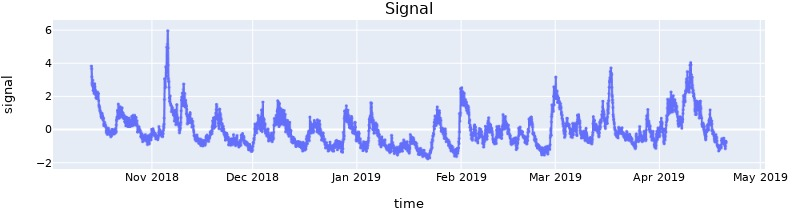

In [53]:
print(f" Signal is sampled at a rate f_s = {fs} Hz. Period is {T}s ")


fig = make_subplots(rows=1, cols=1,
                   subplot_titles=(["Signal"]))

################################################################################
#### Signal
fig.add_trace(go.Scattergl(x=x_date,
                         y=y_signal,
                         mode='markers+lines',
                         marker=dict(size=3),
                         showlegend=False),
                         row=1, col=1)
fig.update_yaxes(title_text="signal",  
#                  type="log",
                 exponentformat= 'power',
                 row=1, col=1)
fig.update_xaxes(title_text="time", exponentformat= 'power',
                 row=1, col=1)
font_dict=dict(family='Arial',size=11,color='black')
# fig=plot_cleanformat_axes(fig,font_dict)

fig.update_layout(#title=f"Signal of interest",
                  autosize=False, height=220, width=800,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict,
    #plot_bgcolor='white', 
                 )
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20),)

fig.show(config = dict({
                'displayModeBar': False,
                'responsive': False,
                'staticPlot': True,
                'displaylogo': False,
                'showTips': False,
                }), 
        renderer='jpg')




# fig = make_subplots(rows=4, cols=1,
#                    subplot_titles=("Signal", "FFT", "LombScargle Periodogram","PSD (welch)" ))
fig = make_subplots(rows=3, cols=1,
                   subplot_titles=( "FFT",  "PSD (periodogram)","LombScargle"),
                   shared_xaxes=True)

################################################################################
#### FFT

N=len(y_signal)
fft_values_ = np.fft.rfft(   y_signal)
power_spectrum = 2.0/N * np.abs(fft_values_[0:N//2])[1:]
freqs       = np.fft.fftfreq(y_signal.size,d=1/fs)
freqs       = freqs[1:N//2]
#
    
    
fig.add_trace(go.Scattergl(x=  (1/freqs)*365,
                         y=  power_spectrum,
                           mode='markers+lines',
                            marker=dict(size=4),
                           opacity=1,
                           showlegend=False),
                           secondary_y=False,row=1, col=1)
fig.update_yaxes(title_text="power",  
                 exponentformat= 'power',
#                            type='log',
                 row=1, col=1)
fig.update_xaxes(exponentformat= 'power',
                 type='log',
                 row=1, col=1)




################################################################################
####  PSD using Periodogram
from scipy.signal import periodogram
def get_psd_values(y_values,  f_s):
    f_values, psd_values = periodogram(y_values, fs=f_s)
    return f_values, psd_values
f_values, psd_values = get_psd_values(y_signal, fs)
f_values  = f_values[1:]
psd_values= psd_values[1:]

fig.add_trace(go.Scattergl(x=  (1/f_values)*365,
                         y=  psd_values,
                           mode='markers+lines',
                               marker=dict(size=4),
                           opacity=1,
                           showlegend=False),
                           secondary_y=False,row=2, col=1)
fig.update_yaxes(title_text="PSD [V**2 / Hz]",  
                 exponentformat= 'power',
#                type='log',
                 row=2, col=1)
fig.update_xaxes(title_text="period [days]", exponentformat= 'power',
                 type='log',
                 row=2, col=1)







###############################################################################
### LOMB_SCARGLE
import scipy.signal as signal
x = t    # times   
y = y_signal  # signal
w = freqs*(2*np.pi) # frequencies
pgram = signal.lombscargle(x, y, w, normalize=False)
pgram= pgram*2*np.pi

fig.add_trace(go.Scattergl(x=  (1/(w/(2*np.pi)))*365,
                         y=  pgram,
                           mode='lines',
                           opacity=1,
                           showlegend=False),
                           secondary_y=False,row=3, col=1)
    
fig.update_yaxes(title_text="amplitude",  
                 exponentformat= 'power',
                 row=3, col=1)
fig.update_xaxes(title_text="Period [days]", exponentformat= 'power',
                 type='log',
                 row=3, col=1)


################################################################################

font_dict=dict(family='Arial',size=11,color='black')
# fig=plot_cleanformat_axes(fig,font_dict)
fig.update_layout(xaxis_showticklabels=True, xaxis2_showticklabels=True)

fig.update_layout(#title=f"Signal of interest",
                  autosize=False, height=500, width=800,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict)

fig.update_layout(margin=dict(l=20, r=20, t=20, b=20),)
fig.show(config = dict({
                'displayModeBar': False,
                'responsive': True,
                'staticPlot': False,
                'displaylogo': False,
                'showTips': False,
                }), 
#         renderer='jpg')
        )

# index_max = np.argmax(psd_values)
# print(f"Dominant frequency at      {f_values[index_max]} Hz")
# print(f"                           {1/f_values[index_max]} s ")
# print(f"                           {1/f_values[index_max]/60/60/24} days ")

# print()
# indexes = np.argsort(psd_values)

# for i in np.arange(1,10):
#     print(f" {1/f_values[indexes[-i]]/60/60/24:5.1f} days")
    


In [54]:
freqs

array([1.93917713e+00, 3.87835427e+00, 5.81753140e+00, ...,
       2.77690166e+03, 2.77884083e+03, 2.78078001e+03])

# Try with gregs funcs

In [ ]:
import pycwt as wavelet
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt


In [ ]:
###--------------------------
y = y_signal
t = x_time
dt = T
N = len(y)
###--------------------------

std2 = y.std()**2


### Define parameters for Wavelet Analysis
mother = wavelet.Morlet(6)  # Morlet mother wavelet with m=6
dj = 1/32                   # Spacing between discrete scales. 


### Perform the wavelet transform and 
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(y, dt, dj=dj, wavelet=mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother)


### Define parameters for siginificance analysis
lag1 = 0.
avg1, avg2 = (2, 8)                  # Range of periods to average
slevel = 0.95                        # Significance level

alpha, _, _ = wavelet.ar1(y)         # Lag-1 autocorrelation for red noise
alpha = 0.


# Normalized wavelet and Fourier power spectra
power = (np.abs(wave)) ** 2 / scales[:, np.newaxis]
fft_power = np.abs(fft) ** 2
period = (1/ freqs)


# Significance test. Where ratio power/sig95 > 1, power is significant.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                        significance_level=slevel, wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Power rectification as of Liu et al. (2007). TODO: confirm if significance 
# test ratio should be calculated first.
#power /= scales[:, None]

# Calculates the global wavelet spectrum and determines its significance level.
glbl_power = power.mean(axis=1)
dof = N - scales                     # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(std2, dt, scales, 1, alpha,
                       significance_level=slevel, dof=dof, wavelet=mother)

# Scale average between avg1 and avg2 periods and significance level
sel = wavelet.helpers.find((period >= avg1) & (period < avg2))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
# As in Torrence and Compo (1998) equation 24
scale_avg = power / scale_avg
scale_avg = std2 * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(std2, dt, scales, 2, alpha,
                            significance_level=slevel, dof=[scales[sel[0]],
                            scales[sel[-1]]], wavelet=mother)


In [ ]:
# plt.semilogx(period, glbl_power)
# plt.semilogx(period, glbl_signif/np.sqrt(scales))

In [ ]:
fig, ax = plt.subplots(figsize=(20,12) )

real_period = np.log2(period)
real_coi = np.log2(coi)
im = ax.pcolormesh(x_date, real_period, power, cmap='viridis')

ax.contour(x_date, real_period, sig95, [-99, 1])
# Hatch the coi where values don't make sense
ax.fill_between(x_date, real_coi, real_period.max(), color="k", alpha=0.4, hatch="x", edgecolor="k")

divider = make_axes_locatable(ax)
#ax1 = divider.append_axes("top", size=1.5, pad=0.1, sharex=ax)
ax2 = divider.append_axes("right", size=1.5, pad=0.1, sharey=ax)
ax3 = divider.append_axes("bottom", size=0.2, pad=0.75)

cbar = plt.colorbar(im, cax = ax3, orientation='horizontal')
#cbar.set_ticks([-200, -150, 0, 150, 200])
cbar.set_label(r"Power (V/m)$^2$")

ax2.plot(glbl_power, real_period, c='b')
ax2.plot(glbl_signif, real_period, c='r')


ax2.yaxis.set_visible(False)

ax.set_xlabel("Time (days)")
ax.set_ylabel("Period (days)")
# ax.set_xlim(x_date.min(), x_date.max())
ax.set_ylim(real_period.max(), real_period.min())

# Change the ticks to the real values, rather than log2 based
ax.set_yticklabels([2**x for x in ax.get_yticks()])

# fig.suptitle("Wavelet Analysis of Neutral Den")

## Wavelet Plot

In [ ]:
################################################################################
import pywt
# perform CWT
wavelet = "cmor1.5-1.0"
widths = np.geomspace(1, 1024, num=100)
sampling_period = np.diff(x_time).mean()
cwtmatr, freqs = pywt.cwt(y_signal, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

In [ ]:
# print(np.shape(x_date))
# print(np.shape(freqs))
# print(np.shape(cwtmatr))

In [ ]:
###### CWT IN TERMS OF FREQUENCY!!!!

import matplotlib.pyplot as plt

################################################################################

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(1, 1, figsize=(20,18))
pcm = axs.pcolormesh(x_date, 1/freqs/60/60/24, cwtmatr)
axs.set_yscale("log")
axs.set_xlabel("Time (s)")
axs.set_ylabel("Frequency (Hz)")
axs.set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs)

# axs.imshow(cwtmatr)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = False
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.titlesize']='large'
plt.rcParams['axes.titlepad']= 2

plt.rcParams["legend.loc"] = 'best'





fig = plt.figure(figsize=(20,12))

ax_sig     = plt.subplot2grid((4,4),(1,2), rowspan = 1, colspan = 2) # top  
ax_psd     = plt.subplot2grid((4,4),(2,1), rowspan = 2, colspan = 1) # side
ax_contour = plt.subplot2grid((4,4),(2,2), rowspan = 2, colspan = 2, sharex=ax_sig, sharey=ax_psd) # bottom

pcm = ax_contour.pcolormesh(x_date, (1/freqs)/60/60/24, cwtmatr)
# pcm = ax_contour.pcolormesh(x_date, freqs, cwtmatr)
ax_contour.set_xlabel("Time (s)")
ax_contour.set_title("CWT Scaleogram of the GFO rho")
# ax_contour.set_yscale("log")
cbaxes = fig.add_axes([.91, 0.125, 0.02, .36])  # [xpos, ypos, width, height]
cb = plt.colorbar(pcm, cax = cbaxes)

###----------------------------------------------------------------------
###   Signal
ax_sig.plot(x_date, y_signal,   '-')
ax_sig.set_title("Orbit Averaged GFO Density")
ax_sig.set_ylabel("Orbit Avg Density")
# ax_sig.set_yscale("log")

ax_sig.xaxis.set_visible(False) # Hide only x axis

###----------------------------------------------------------------------
###   PERIODOGRAM
from scipy.signal import periodogram
def get_psd_values(y_values,  f_s):
    f_values, psd_values = periodogram(y_values, fs=f_s)
    return f_values, psd_values
f_values, psd_values = get_psd_values(y_signal, fs)
f_values  = f_values[1:]
psd_values= psd_values[1:]
# ax_psd.plot(psd_values, 1/f_values,   '-')
ax_psd.plot(psd_values, 1/f_values/60/60/24,   '-')

for i in [np.arange(1,8)]:
    print(f" {(1/f_values)[indexes[-i]]:} d")
    ax_psd.plot(psd_values[indexes[-i]], (1/f_values)[indexes[-i]],  '.', markersize=10)


ax_psd.invert_xaxis()
ax_psd.set_ylim([0, 68])
ax_psd.set_ylabel("Period (days)")
ax_psd.set_title("PSD- Periodogram")
fig.constrained_layout=True 
# fig.tight_layout(pad=0)



In [ ]:
index_max = np.argmax(psd_values)
print(f"Dominant frequency at      {f_values[index_max]} Hz")
# print(f" correspondes to period at {1/f_values[index_max]} s ")
# print(f"                           {1/f_values[index_max]/60} m ")
# print(f"                           {1/f_values[index_max]/60/60} h ")
print(f"                           {1/f_values[index_max]/60/60/24} d ")

print()
indexes = np.argsort(psd_values)

for i in np.arange(1,10):
    print(f" {1/f_values[indexes[-i]]/60/60/24:5.1f} d")


In [ ]:
sys.exit(0)

In [ ]:

fig = go.Figure(data =
    go.Contour(
        z=cwtmatr,
        x=x_time, # horizontal axis
        y=freqs, # vertical axis
#             contours_coloring='heatmap',
            colorscale='Viridis',
))

fig.update_yaxes(title_text="Frequency [Hz]", exponentformat= 'power',
                 type='log')
fig.update_xaxes(title_text="Time", exponentformat= 'power')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20),)

fig.update_layout(title=f"CWT--'cmor1.5-1.0'",
#                   autosize=False, height=220, width=800,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict,
    #plot_bgcolor='white', 
                 )

fig.show(config = dict({
                'displayModeBar': False,
                'responsive': False,
                'staticPlot': True,
                'displaylogo': False,
                'showTips': False,
                }), 
        renderer='jpg')

In [ ]:
1/5400

# NOTES AND SCRAP

### chirp option

In [ ]:
# def gaussian(x, x0, sigma):
#     return np.exp(-np.power((x - x0) / sigma, 2.0) / 2.0)


# def make_chirp(t, t0, a):
#     frequency = (a * (t + t0)) ** 2
#     chirp = np.sin(2 * np.pi * frequency * t)
#     return chirp, frequency


# # generate signal
# time = np.linspace(0, 1, 2000)
# chirp1, frequency1 = make_chirp(time, 0.2, 9)
# chirp2, frequency2 = make_chirp(time, 0.1, 5)
# chirp = chirp1 + 0.6 * chirp2
# chirp *= gaussian(time, 0.5, 0.2)
# # print(f"Frequencies at {frequency1} Hz and {frequency2} Hz")

###  sin wave

Here we have five sine-waves with amplitudes 4, 6, 8, 10 and 14 and frequencies 6.5, 5, 3, 1.5 and 1 Hz. By combining these signals we form a new composite signal . The Fourier Transform transforms this signal to the frequency-domain and shows us at which frequencies the component signals oscillate.

In [ ]:
t_n = 10
N = 1000
T = t_n / N  # period
fs = 1/T   

x_value = np.linspace(0,t_n,N)
amplitudes = [4, 6, 8, 10, 14]
frequencies = [6.5, 5, 3, 1.5, 1]
y_values = [amplitudes[ii]*np.sin(2*np.pi*frequencies[ii]*x_value) for ii in range(0,len(amplitudes))]
composite_y_value = np.sum(y_values, axis=0)
print(f"Frequencies at {frequencies} Hz")


print(f" Signal is sampled at a rate f_s = {fs} Hz. Period is {T}s ")
# print(f" the FFT will return the frequency spectrum up to a frequency of f_s / 2 = {f_s/2}Hz")


### Set variables

In [ ]:
# y_signal =  chirp 
# x_dates  =  time 
# N        = len(y_signal)
# x_time   = np.linspace(0, 1, N)



In [ ]:
y_signal =  composite_y_value 
x_dates  =  x_value 
N        = len(y_signal)
x_time   = np.linspace(0, 1, N)



### Plot the signal

In [ ]:
### should set it to be twice the nyquist frequency
### maybe 
print(f"fs = {fs} Hz")
print(f"Expecting the following frequencies: {frequencies} Hz")
print(f"         @ corresponding amplitudes: {amplitudes} ")


fig = make_subplots(rows=1, cols=1,
                   subplot_titles=("Signal"))

################################################################################
#### Signal
fig.add_trace(go.Scattergl(x=x_dates,
                         y=y_signal,
                         mode='markers+lines',
                         marker=dict(size=3),
                         showlegend=False),
                         row=1, col=1)
fig.update_yaxes(title_text="signal",  
                 type="linear", exponentformat= 'power',
                 row=1, col=1)
fig.update_xaxes(title_text="time", exponentformat= 'power',
                 row=1, col=1)
font_dict=dict(family='Arial',size=11,color='black')
# fig=plot_cleanformat_axes(fig,font_dict)

fig.update_layout(#title=f"Signal of interest",
                  autosize=False, height=220, width=800,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict,
    #plot_bgcolor='white', 
                 )
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20),)

fig.show(config = dict({
                'displayModeBar': False,
                'responsive': False,
                'staticPlot': True,
                'displaylogo': False,
                'showTips': False,
                }), 
        renderer='jpg')




# fig = make_subplots(rows=4, cols=1,
#                    subplot_titles=("Signal", "FFT", "LombScargle Periodogram","PSD (welch)" ))
fig = make_subplots(rows=3, cols=1,
                   subplot_titles=( "FFT",  "PSD (periodogram)","PSD (welch)"),
                   shared_xaxes=True)

################################################################################
#### FFT
fft_values_ = np.fft.rfft(   y_signal)
power_spectrum = 2.0/N * np.abs(fft_values_[0:N//2])
freqs       = np.fft.fftfreq(y_signal.size,d=1/fs)
freqs       = freqs[0:N//2]
fig.add_trace(go.Scattergl(x=  freqs,
                         y=  power_spectrum,
                           mode='lines',
                           opacity=1,
                           showlegend=False),
                           secondary_y=False,row=1, col=1)
fig.update_yaxes(title_text="power",  
                 exponentformat= 'power',
                 row=1, col=1)
fig.update_xaxes(title_text="Frequency [Hz]", exponentformat= 'power',
                 type='log',
                 row=1, col=1)


################################################################################
#### LOMB_SCARGLE
# import scipy.signal as signal
# x = x_time    # times   
# y = y_signal  # signal
# w = freqs[1:] # frequencies
# pgram = signal.lombscargle(x, y, w, normalize=False)

# fig.add_trace(go.Scattergl(x=  w,
#                          y=  pgram,
#                            mode='lines',
#                            opacity=1,
#                            showlegend=False),
#                            secondary_y=False,row=3, col=1)
# fig.update_yaxes(title_text="amplitude",  
#                  exponentformat= 'power',
#                  row=3, col=1)
# fig.update_xaxes(title_text="Frequency [Hz]", exponentformat= 'power',
# #                  type='log',
#                  row=3, col=1)

################################################################################
####  PSD using Periodogram
from scipy.signal import periodogram

def get_psd_values(y_values,  f_s):
    f_values, psd_values = periodogram(y_values, fs=f_s)
    return f_values, psd_values

f_values, psd_values = get_psd_values(y_signal, fs)
fig.add_trace(go.Scattergl(x=  f_values,
                         y=  psd_values,
                           mode='lines',
                           opacity=1,
                           showlegend=False),
                           secondary_y=False,row=2, col=1)
fig.update_yaxes(title_text="PSD [V**2 / Hz]",  
                 exponentformat= 'power',
                 row=2, col=1)
fig.update_xaxes(title_text="Frequency [Hz]", exponentformat= 'power',
                 type='log',
                 row=2, col=1)
################################################################################
#### Welch PSD
from scipy.signal import welch
def get_psd_values(y_values,  f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

f_values, psd_values = get_psd_values(y_signal, fs)
fig.add_trace(go.Scattergl(x=  f_values,
                         y=  psd_values,
                           mode='lines',
                           opacity=1,
                           showlegend=False),
                           secondary_y=False,row=3, col=1)
fig.update_yaxes(title_text="PSD [V**2 / Hz]",  
                 exponentformat= 'power',
                 row=3, col=1)
fig.update_xaxes(title_text="Frequency [Hz]", exponentformat= 'power',
                 type='log',
                 row=3, col=1)



################################################################################

font_dict=dict(family='Arial',size=11,color='black')
# fig=plot_cleanformat_axes(fig,font_dict)
fig.update_layout(xaxis_showticklabels=True, xaxis2_showticklabels=True)

fig.update_layout(#title=f"Signal of interest",
                  autosize=False, height=700, width=800,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict)

fig.update_layout(margin=dict(l=20, r=20, t=20, b=20),)
fig.show(config = dict({
                'displayModeBar': False,
                'responsive': False,
                'staticPlot': True,
                'displaylogo': False,
                'showTips': False,
                }), 
        renderer='jpg')




In [ ]:
fig = make_subplots(rows=1, cols=1,
                   subplot_titles=("Signal"))

################################################################################
#### Signal
fig.add_trace(go.Scattergl(x=x_dates,
                         y=y_signal,
                         mode='markers+lines',
                         marker=dict(size=3),
                         showlegend=False),
                         row=1, col=1)
fig.update_yaxes(title_text="signal",  
                 type="linear", exponentformat= 'power',
                 row=1, col=1)
fig.update_xaxes(title_text="time", exponentformat= 'power',
                 row=1, col=1)
font_dict=dict(family='Arial',size=11,color='black')
# fig=plot_cleanformat_axes(fig,font_dict)

fig.update_layout(#title=f"Signal of interest",
                  autosize=False, height=220, width=800,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict,
    #plot_bgcolor='white', 
                 )
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20),)

fig.show(config = dict({
                'displayModeBar': False,
                'responsive': False,
                'staticPlot': True,
                'displaylogo': False,
                'showTips': False,
                }), 
        renderer='jpg')

################################################################################
import pywt
# perform CWT
wavelet = "cmor1.5-1.0"
# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.geomspace(1, 1024, num=100)
sampling_period = np.diff(x_dates).mean()
cwtmatr, freqs = pywt.cwt(y_signal, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])


fig = go.Figure(data =
    go.Contour(
        z=cwtmatr,
        x=x_dates, # horizontal axis
        y=freqs, # vertical axis
#             contours_coloring='heatmap',
            colorscale='Viridis',
))

fig.update_yaxes(title_text="Frequency [Hz]", exponentformat= 'power',
                 type='log')
fig.update_xaxes(title_text="Time", exponentformat= 'power')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20),)

fig.update_layout(title=f"CWT--'cmor1.5-1.0'",
#                   autosize=False, height=220, width=800,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict,
    #plot_bgcolor='white', 
                 )

fig.show()


In [ ]:
cwtmatr.shape



In [ ]:
x_dates

In [ ]:
freqs

In [ ]:
import sys
sys.exit(0)

In [ ]:
import sys
sys.exit()

## Frequency analysis
In simple terms, the Continuous Wavelet Transform is an analysis tool similar to the Fourier Transform, in that it takes a time-domain signal and returns the signal’s components in the frequency domain. However, in contrast to the Fourier Transform, the Continuous Wavelet Transform returns a two-dimensional result, providing information in the frequency- as well as in time-domain. Therefore, it is useful for periodic signals which change over time.


In [ ]:
import numpy as np
import pywt





In [ ]:
# # plot fourier transform for comparison
# from numpy.fft import rfft, rfftfreq

# fig, axs = plt.subplots(1, 1, sharex=True)

# yf = rfft(y_signal)
# xf = rfftfreq(len(y_signal), sampling_period)
# plt.semilogx(xf, np.abs(yf))
# axs.set_xlabel("Frequency (Hz)")
# axs.set_title("Fourier Transform")
# plt.tight_layout()

In [ ]:
print(len(y_signal))
print(len(time))
freqs[:len(power_spectrum)]

In [ ]:
fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.semilogy(x, y, 'b+')
ax_t.set_xlabel('Time [s]')
ax_w.semilogx(w, pgram)
ax_w.set_xlabel('frequency')
ax_w.set_ylabel('amplitude')
plt.show()

In [ ]:
w

In [ ]:
print(f" dominant frequncy {1/115.5827789} periods  ")

In [ ]:
((1/115.5827789)*9*86400)/60

In [ ]:
w

In [ ]:
# perform CWT
wavelet = "cmor1.5-1.0"

# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.geomspace(1, 1024, num=100)
sampling_period = np.diff(time).mean()
cwtmatr, freqs = pywt.cwt(y_signal, widths, wavelet, sampling_period=sampling_period)

# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1)
pcm = axs[0].pcolormesh(time, freqs, cwtmatr)
axs[0].set_yscale("log")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
from numpy.fft import rfft, rfftfreq

yf = rfft(y_signal)
xf = rfftfreq(len(y_signal), sampling_period)
plt.semilogx(xf, np.abs(yf))
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_title("Fourier Transform")
plt.tight_layout()

In [ ]:
cwtmatr
# freqs

In [ ]:
import sys
sys.exit()

In [ ]:
from scipy.fftpack import fft
import matplotlib.pyplot as plt


def get_fft_values(y_values, T, N, f_s):
    '''get_fft_values function above, the scipy.fftpack.fft function returns
       a vector of complex valued frequencies. Since they are complex valued,
       they will contain a real and an imaginary part. The real part of the 
       complex value corresponds with the magnitude, and the imaginary part 
       with the phase of the signal. Since we are only interested in the 
       magnitude of the amplitudes, we use np.abs() to take the real part of
       the frequency spectrum.
       The FFT of an input signal of N points, will return an vector of N points.
       The first half of this vector (N/2 points) contain the useful values of 
       the frequency spectrum from 0 Hz up to the Nyquist frequency of f_s / 2.
       The second half contains the complex conjugate and can be disregarded 
       since it does not provide any useful information.
       '''
    
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values



y_vals = gfo_df['D500_gfo'].values

t_n = 10
f_s = 0.1
N = len(y_vals)
T = t_n / N

print(f" Signal is sampled at a rate f_s = {f_s} Hz (or {1/f_s} s)")
print(f" the FFT will return the frequency spectrum up to a frequency of f_s / 2 = {f_s/2}Hz")

x_value = np.linspace(0,t_n,N)

f_values, fft_values = get_fft_values(y_vals, T, N, f_s)


### PLOT ###################################################################
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scattergl(  x=f_values,
                           y=fft_values,
                           mode='lines',
                           showlegend=False),
                           row=1, col=1)

font_dict=dict(family='Arial',size=11,color='black')
fig=plot_cleanformat_axes(fig,font_dict)

fig.update_yaxes(title_text="Amplitude",  
                  exponentformat= 'power',
                 row=1, col=1)
fig.update_xaxes(title_text="Frequency [Hz]", exponentformat= 'power',
                 type="log", row=1, col=1)

fig.update_layout(title=f"Frequency domain of the signal",
                  autosize=True,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict, plot_bgcolor='white', 
                 )
fig.show(config = dict({
                'displayModeBar': False,'responsive': False,'staticPlot': True,
                'displaylogo': False,'showTips': False,}), 
        renderer='jpg')

# plt.semilogy(f_values, fft_values, linestyle='-', color='blue')
# plt.xlabel('Frequency [Hz]', fontsize=16)
# plt.ylabel('Amplitude', fontsize=16)
# plt.title("Frequency domain of the signal", fontsize=16)
# plt.show()
###################################################################

from scipy.signal import welch
 
def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values
 
f_values, psd_values = get_psd_values(y_vals, T, N, f_s)
 
# plt.plot(f_values, psd_values, linestyle='-', color='blue')
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('PSD [V**2 / Hz]')
# plt.show()

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scattergl(  x=f_values,
                           y=psd_values,
                           mode='lines',
                           showlegend=False),
                           row=1, col=1)

font_dict=dict(family='Arial',size=11,color='black')
fig=plot_cleanformat_axes(fig,font_dict)

fig.update_yaxes(title_text="PSD [V**2 / Hz]",  
                 exponentformat= 'power',
                 row=1, col=1)
fig.update_xaxes(title_text="Frequency [Hz]", exponentformat= 'power',
                 row=1, col=1)

fig.update_layout(title=f"PSD",
                  autosize=True,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict, plot_bgcolor='white', 
                 )
fig.show(config = dict({
                'displayModeBar': False,'responsive': False,'staticPlot': True,
                'displaylogo': False,'showTips': False,}), 
        renderer='jpg')

## El nino example

###  Load the el-Nino time-series 

In [ ]:
####  https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/



import os
import pywt
#from wavelets.wave_python.waveletFunctions import *
import itertools
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

In [ ]:
dataset = "https://raw.githubusercontent.com/taspinar/siml/master/datasets/sst_nino3.dat.txt"
df_nino = pd.read_table(dataset)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()
print(f"N {N}")
# print(f"{}")
# print(f"{}")
# print(f"{}")

In [ ]:
time

In [ ]:
df_nino

In [ ]:
# First lets load the el-Nino dataset, and plot it together with its time-average

def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(ax, time, signal, average_over = 5):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Amplitude', fontsize=16)
    ax.set_title('Signal + Time Average', fontsize=16)
    ax.legend(loc='upper right')

fig, ax = plt.subplots(figsize=(12,3))
plot_signal_plus_average(ax, time, signal, average_over = 3)
plt.show()

### Plot the Fourier Transform of the el-Nino dataset

In [ ]:

def get_fft_values(y_values, T, N, f_s):
    N2 = 2 ** (int(np.log2(N)) + 1) # round up to next highest power of 2
    f_values = np.linspace(0.0, 1.0/(2.0*T), N2//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N2 * np.abs(fft_values_[0:N2//2])
    return f_values, fft_values

def plot_fft_plus_power(ax, time, signal, plot_direction='horizontal', yticks=None, ylim=None):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2
    if plot_direction == 'horizontal':
        ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
        ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        scales_log = np.log2(scales)
        ax.plot(fft_values, scales_log, 'r-', label='Fourier Transform')
        ax.plot(fft_power, scales_log, 'k--', linewidth=1, label='FFT Power Spectrum')
        ax.set_yticks(np.log2(yticks))
        ax.set_yticklabels(yticks)
        ax.invert_yaxis()
        ax.set_ylim(ylim[0], -1)
    ax.legend()

fig, ax = plt.subplots(figsize=(12,3))
ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
ax.set_ylabel('Amplitude', fontsize=18)
plot_fft_plus_power(ax, time, signal)
plt.show()

In [ ]:
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()

def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()

dataset = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"
df_nino = pd.read_table(dataset)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()

scales = np.arange(1, 128)
plot_signal_plus_average(time, signal)
plot_fft_plus_power(time, signal)
plot_wavelet(time, signal, scales)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [sample_rate * kk for kk in range(0,len(y_values))]
    return x_values, y_values

####

labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"

xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Acceleration', 'Gyro', 'Total acceleration'],
            ['FFT acc', 'FFT gyro', 'FFT total acc'],
            ['PSD acc', 'PSD gyro', 'PSD total acc'],
            ['Autocorr acc', 'Autocorr gyro', 'Autocorr total acc']
           ]

list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]

N = 128
f_s = 50
t_n = 2.56
T = t_n / N

signal_no = 0
signals = train_signals[signal_no, :, :]
label = train_labels[signal_no]
activity_name = activities_description[label]

f, axarr = plt.subplots(nrows=4, ncols=3, figsize=(12,12))
f.suptitle(suptitle.format(activity_name), fontsize=16)

for row_no in range(0,4):
    for comp_no in range(0,9):
        col_no = comp_no // 3
        plot_no = comp_no % 3
        color = colors[plot_no]
        label = labels[plot_no]

        axtitle  = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = list_functions[row_no]

        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)

        signal_component = signals[:, comp_no]
        x_values, y_values = value_retriever(signal_component, T, N, f_s)
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
        if row_no &gt; 0:
            max_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = detect_peaks(y_values, mph=max_peak_height)
            ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

In [ ]:
################################################################################
#### LOMB_SCARGLE
# import scipy.signal as signal
# x = x_time    # times   
# y = y_signal  # signal
# w = freqs[1:] # frequencies
# pgram = signal.lombscargle(x, y, w, normalize=False)

# fig.add_trace(go.Scattergl(x=  w,
#                          y=  pgram,
#                            mode='lines',
#                            opacity=1,
#                            showlegend=False),
#                            secondary_y=False,row=3, col=1)
# fig.update_yaxes(title_text="amplitude",  
#                  exponentformat= 'power',
#                  row=3, col=1)
# fig.update_xaxes(title_text="Frequency [Hz]", exponentformat= 'power',
# #                  type='log',
#                  row=3, col=1)